In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/Saint-Petersburg.json


In [16]:
df = pd.read_json (r'/kaggle/input/Saint-Petersburg.json')

In [17]:
def show_missing(df):
    missing = df.columns[df.isnull().any()].tolist()
    return df[missing].info()

In [18]:
df['id'] = df.index

In [19]:
show_missing(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   foursquare_checkinsCount   882 non-null    float64
 1   foursquare_rating          540 non-null    float64
 2   foursquare_ratingVotes     540 non-null    float64
 3   foursquare_userCount       882 non-null    float64
 4   instagram_visitorsNumber   2938 non-null   float64
 5   tripAdvisor_link           1279 non-null   object 
 6   tripAdvisor_rating         1279 non-null   float64
 7   tripAdvisor_reviewsNumber  1279 non-null   float64
dtypes: float64(7), object(1)
memory usage: 312.6+ KB


In [20]:
def fillna(df):
    for col in df.columns:
        for i, value in enumerate(df['tripAdvisor_rating'].values):
            if np.isnan(value):
                df['tripAdvisor_rating'][i] = df['foursquare_rating'][i]/2



In [21]:
fillna(df)

In [22]:
df= df.drop (columns= ['address','foursquare_checkinsCount','foursquare_rating','foursquare_ratingVotes', 'foursquare_userCount', 'lat', 'lng', 'open_hours', 'title','tripAdvisor_link', 'tripAdvisor_reviewsNumber', 'x', 'y', 'tripAdvisor_link', 'foursquare_rating'])

In [23]:
show_missing(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   instagram_visitorsNumber  2938 non-null   float64
 1   tripAdvisor_rating        1764 non-null   float64
dtypes: float64(2)
memory usage: 78.2 KB


In [24]:
df[['instagram_visitorsNumber']]= df[['instagram_visitorsNumber']].fillna(value=0)

Построение модели

In [25]:
train=df[df.tripAdvisor_rating.notnull()]
test=df[df.tripAdvisor_rating.isnull()]

train_labels = train['tripAdvisor_rating'].reset_index(drop=True)
train_features = train.drop(['tripAdvisor_rating'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape


(5000, 6)


 mu = 4.12 and sigma = 0.88



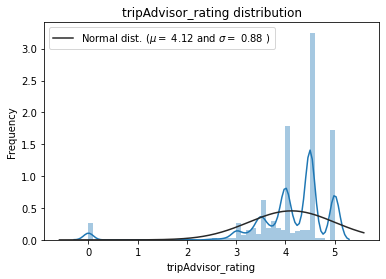

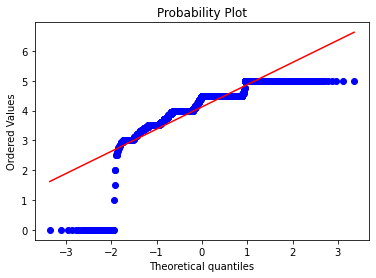

In [26]:
from scipy import stats
from scipy.stats import norm, skew
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(train['tripAdvisor_rating'], fit=norm);


# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['tripAdvisor_rating'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('tripAdvisor_rating distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['tripAdvisor_rating'], plot=plt)
plt.show()


 mu = 1.61 and sigma = 0.29



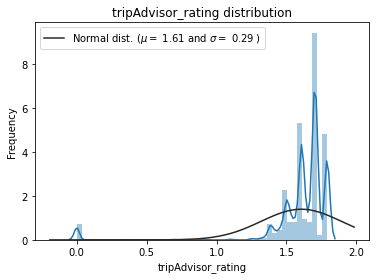

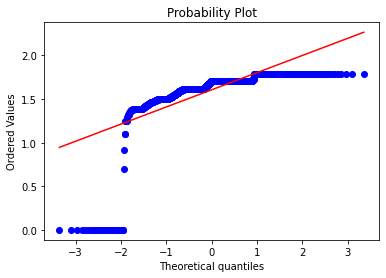

In [27]:
#Распределение скошено направо, произведем изменения, чтобы распределение было нормальным
train["tripAdvisor_rating"] = np.log1p(train["tripAdvisor_rating"])

#График нового распределения
sns.distplot(train['tripAdvisor_rating'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['tripAdvisor_rating'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('tripAdvisor_rating distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['tripAdvisor_rating'], plot=plt)
plt.show()

In [28]:
#Берем только количественные переменные
numeric_feats = all_features.dtypes[all_features.dtypes != "object"].index

#Проверяем распределение переменных на скошенность 
skewed_feats = all_features[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
instagram_visitorsNumber,15.877520
officialGuide,6.393980
duration,1.841288
id,0.000000
tripAdvisor_rating,NaN


In [29]:
skewness = skewness[abs(skewness) > 15]
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_features[feat] = boxcox1p(all_features[feat], lam)

In [30]:
df1 = pd.get_dummies(pd.DataFrame(df.pop('category').values.tolist()), prefix='', prefix_sep='').groupby(axis=1, level=0).max()
df1 = pd.concat([df1, df], axis=1)

In [31]:
df1= pd.DataFrame(df1)
df1.head()
df=df1

In [32]:
#Снова разделяем наши данные на тестовую и обучающую выборку
train=df[df.tripAdvisor_rating.notnull()]
test=df[df.tripAdvisor_rating.isnull()]
test=test.drop(columns='tripAdvisor_rating')

train_labels = train['tripAdvisor_rating'].reset_index(drop=True)
train_features = train.drop(['tripAdvisor_rating'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape


y = train['tripAdvisor_rating'].reset_index(drop=True)
X = all_features.iloc[:len(y), :]
X_sub = all_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1764, 9), (1764,), (3236, 9))

In [33]:
#Бдуем использовать кросс валидацию с 10 фолдами
kfolds = KFold(n_splits=15, shuffle=True, random_state=42)

#Функции для подсчета ошибки 
def rmsle(y, y_pred): 
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [34]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [35]:
#Так как регрессии не устойчивы к выбросам, то применим к ним RobustScaler()
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [36]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)

In [37]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [38]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [39]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [40]:
score = cv_rmse(ridge)
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LASSO: 0.8623 (0.1257)

elastic net: 0.8623 (0.1257)

SVR: 0.9081 (0.1531)

lightgbm: 0.8767 (0.1265)

gbr: 0.8920 (0.1472)

[17:33:18] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:20] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:23] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:26] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:28] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:31] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:34] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:

In [41]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[17:34:35] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:34:38] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:34:40] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:34:42] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:34:45] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:34:51] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:04] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost
[17:35:16] WARNING: /workspace/src/obje

In [42]:
def blend_models_predict(X):
    return ((0.3 * elastic_model_full_data.predict(X)) + \
            (0.3 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.05 * svr_model_full_data.predict(X)) + \
            (0.05 * gbr_model_full_data.predict(X)) + \
            (0.05 * xgb_model_full_data.predict(X)) + \
            (0.05 * lgb_model_full_data.predict(X)) + \
            (0.1 * stack_gen_model.predict(np.array(X))))

In [43]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.8537619105467708


In [44]:
predictions = blend_models_predict(X_sub)


In [45]:
dataframe=pd.DataFrame(predictions, columns=['tripAdvisor_rating'])

In [46]:
dataframe.tripAdvisor_rating = round(dataframe.tripAdvisor_rating,3)


In [47]:
test['tripAdvisor_rating']=0
test['tripAdvisor_rating']=dataframe['tripAdvisor_rating']
test.head()


,Concerts & Shows,Museums & Libraries,Nature & Parks,Restaurant,Sights & Landmarks,duration,instagram_visitorsNumber,officialGuide,id,tripAdvisor_rating
0,0,0,0,0,1,15,61.0,0,0,4.159
1,0,0,0,0,1,15,415.0,0,1,4.094
3,0,0,0,0,1,15,354.0,0,3,4.242
5,0,1,0,0,1,120,1094.0,0,5,4.180
6,0,0,0,0,1,15,123.0,0,6,4.139


In [48]:
train.head()

,Concerts & Shows,Museums & Libraries,Nature & Parks,Restaurant,Sights & Landmarks,duration,instagram_visitorsNumber,officialGuide,tripAdvisor_rating,id
2,0,0,0,0,1,15,0.0,0,4.5,2
4,0,1,0,0,0,120,0.0,0,4.5,4
9,0,0,0,0,1,15,0.0,0,4.0,9
10,0,0,0,0,1,15,0.0,0,5.0,10
11,0,0,0,0,1,15,0.0,0,0.0,11


In [49]:
train=pd.DataFrame(train)
test=pd.DataFrame(test)

In [51]:
result = pd.concat([train,test])

result= result.sort_values(by=['id'])
result.head()

result= result[['id',  'tripAdvisor_rating']]

In [52]:
result.head()

,id,tripAdvisor_rating
0,0,4.159
1,1,4.094
2,2,4.500
3,3,4.242
4,4,4.500


In [53]:
df_full= pd.read_json (r'/kaggle/input/Saint-Petersburg.json')
df_full['tripAdvisor_rating'] = result['tripAdvisor_rating']

NameError: name 'df_full' is not defined

In [ ]:
df_full.to_csv("df_full.csv", index=False)